## Abstract

El presente trabajo analiza un conjunto representativo de bonos soberanos de la República Argentina, emitidos bajo ley local y ley extranjera, con el objetivo de identificar patrones de precios y liquidez relevantes para la toma de decisiones de inversión. El análisis está orientado a un público inversor, tanto institucional como minorista, que busca comprender las dinámicas actuales de la curva soberana en moneda extranjera y detectar oportunidades en función de la estructura de precios y la actividad operativa.

A partir de datos provenientes de una API pública del mercado (Open BYMA Data), se examinan precios limpios, volúmenes operados y otras métricas clave para diez bonos seleccionados. El enfoque se centra en comparar diferencias entre jurisdicciones legales, evaluar la existencia de primas por liquidez, identificar rangos de precios asociados a distintos tramos de vencimiento y analizar la relación entre precio y volumen negociado.

Los resultados permiten obtener una visión clara de las condiciones de mercado vigentes y establecer lineamientos para estrategias de inversión y gestión de riesgos en el contexto actual del mercado argentino de renta fija.


## Hipótesis de trabajo

1. **Diferencias de precio entre ley local y ley extranjera**  
   En un mismo tramo de vencimiento, los bonos emitidos bajo ley extranjera tienden a mostrar precios más altos por una menor percepción de riesgo legal.

2. **Prima por liquidez**  
   Los bonos con mayor volumen operado presentan precios más competitivos, reflejando el valor que los inversores asignan a la facilidad de entrada y salida.

3. **Rangos de precios por vencimiento**  
   Los precios de los bonos tienden a agruparse por tramos de vencimiento (corto, medio y largo), lo que refleja la estructura implícita de la curva soberana.

4. **Relación precio–volumen**  
   Existe una asociación entre el volumen negociado y el nivel de precio, que podría vincularse a diferencias en la demanda relativa de los instrumentos.


In [7]:
# Instalamos librerías necesarias
!pip install pandas numpy matplotlib plotly requests python-dateutil --quiet

# Importamos las librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import datetime as dt
from dateutil.relativedelta import relativedelta

# Configuración visual básica
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (9,4)

print("✅ Librerías instaladas e importadas correctamente")


✅ Librerías instaladas e importadas correctamente


In [8]:
# 1) Carpetas del proyecto y parámetros base
import os, datetime as dt
import pandas as pd

# Carpetas (estas carpetas las creo de manera local para guardar lo que bajo de la API después)
BASE = "/content"
DATA_RAW = f"{BASE}/data/raw"        # datos crudos (desde API)
DATA_INT = f"{BASE}/data/interim"    # datos intermedios / limpios
DATA_OUT = f"{BASE}/data/processed"  # outputs / tablas finales
for p in (DATA_RAW, DATA_INT, DATA_OUT):
    os.makedirs(p, exist_ok=True)

# 2) Analizamos 10 bonos soberanos (esto lo puedo ajustar segun mi requerimiento en cualquier momento , solo hace falta cambiar el ticker de los BONOS)
UNIVERSE = ["AL29","AL30","AL35","AL41","GD29","GD30","GD35","GD38","GD41","AE38"]

# 3) Ventana temporal , basicamente es desde que periodo me traigo los datos historicos de los bosnos que vamos a analizar
START_DATE = "2023-01-01"
END_DATE = dt.date.today().isoformat()

print("✅ Listo. Carpetas creadas y parámetros definidos.")
print("UNIVERSE:", UNIVERSE)
print("Rango:", START_DATE, "→", END_DATE)


✅ Listo. Carpetas creadas y parámetros definidos.
UNIVERSE: ['AL29', 'AL30', 'AL35', 'AL41', 'GD29', 'GD35', 'GD38', 'GD41', 'AE38']
Rango: 2023-01-01 → 2025-08-14


In [9]:
# ================================================
# 4) CREAR EL ESQUEMA VACÍO PARA GUARDAR DATOS DE LA API
# ================================================
# La idea es definir desde el inicio cómo será la "planilla" donde
# vamos a ir guardando los datos que traigamos de la API de BYMA.
# Esto asegura que cada vez que descarguemos datos tengan el mismo formato
# y podamos analizarlos sin problemas.

import pandas as pd
from pathlib import Path

# --- 1. Defino los nombres de las columnas que va a tener mi tabla ---
# Esto es como escribir los títulos de un Excel.
COLUMNS = [
    "date",          # Fecha de la observación (YYYY-MM-DD)
    "ticker",        # Código del bono (AL30, GD30, etc.)
    "price_clean",   # Precio limpio (sin cupón corrido)
    "price_dirty",   # Precio sucio (incluye cupón corrido)
    "volume",        # Volumen operado en el día
    "currency",      # Moneda en la que cotiza (USD o ARS)
    "source"         # Fuente del dato (ej: 'BYMA-EOD')
]

# --- 2. Creo un DataFrame vacío con esas columnas ---
# Es mi "planilla en blanco" en memoria, todavía sin filas.
raw_df = pd.DataFrame(columns=COLUMNS)

# --- 3. Defino los tipos de datos que debería tener cada columna ---
# Esto sirve como referencia para asegurar consistencia al cargar datos reales.
DTYPES = {
    "ticker": "string",
    "price_clean": "float64",
    "price_dirty": "float64",
    "volume": "float64",
    "currency": "string",
    "source": "string",
}

# --- 4. Función para validar que un DataFrame tenga el esquema correcto ---
# Si un DataFrame no tiene todas las columnas esperadas, me avisa.
def validate_schema(df, cols=COLUMNS):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas: {missing}")
    return True

# --- 5. Guardo este DataFrame vacío como CSV ---
# Esto es como guardar un Excel vacío con los encabezados definidos.
outfile = Path(DATA_RAW) / "quotes_schema_empty.csv"
raw_df.to_csv(outfile, index=False)

# --- 6. Confirmo que todo salió bien y muestro el resultado ---
print("✅ Esquema creado y CSV guardado (vacío).")
print("Ruta:", outfile)
print("Columnas:", list(raw_df.columns))

# Muestro las primeras filas (estará vacío pero con columnas listas)
display(raw_df.head(2))


✅ Esquema creado y CSV guardado (vacío).
Ruta: /content/data/raw/quotes_schema_empty.csv
Columnas: ['date', 'ticker', 'price_clean', 'price_dirty', 'volume', 'currency', 'source']


,date,ticker,price_clean,price_dirty,volume,currency,source


In [12]:
# =========================================================
#  Open BYMA Data con PyOBD (delay ~20 min)
# Objetivo: descargar cotizaciones de BONOS soberanos,
# filtrar 10 tickers, mapear a un esquema uniforme y guardar CSVs.
# =========================================================

# 0) Instalación de PyOBD (desde GitHub) — solo hace falta una vez por sesión
!pip install --quiet git+https://github.com/franco-lamas/PyOBD --no-cache-dir

# 1) Imports y configuración de rutas
#    Explico: usamos las mismas carpetas del proyecto para no mezclar archivos.
from PyOBD import openBYMAdata
import pandas as pd
import numpy as np
from pathlib import Path
import os, datetime as dt

BASE = "/content"
DATA_RAW = f"{BASE}/data/raw"        # datos crudos (lo que baja PyOBD)
DATA_INT = f"{BASE}/data/interim"    # datos intermedios (combinados / limpios)
DATA_OUT = f"{BASE}/data/processed"  # resultados/outputs finales
for p in (DATA_RAW, DATA_INT, DATA_OUT):
    os.makedirs(p, exist_ok=True)

# 2) Universo de 10 bonos (lo fijamos explícitamente)
#    Explico: definimos aquí los tickers para iterar y filtrar exactamente estos.
UNIVERSE = ["AL29","AL30","AL35","AL41","GD29","GD30","GD35","GD38","GD41","AE38"]

# 3) Esquema de columnas que voy a exigir en todos los CSVs
#    Explico: esto es "mi contrato" de datos. Me asegura consistencia para el EDA/modelos.
COLUMNS = ["date","ticker","price_clean","price_dirty","volume","currency","source"]

# 4) Descarga del panel de bonos con PyOBD
#    Explico: PyOBD consulta Open BYMA Data con ~20 min de delay. Es suficiente para EDA y la entrega.
obd = openBYMAdata()
df_raw = obd.get_bonds()   # panel general de bonos

# 5) Normalización de nombres de columnas (las paso a minúscula para evitar errores)
df = df_raw.copy()
df.columns = [c.lower().strip() for c in df.columns]

# 6) Detección flexible de columnas (cada fuente puede variar cómo nombra los campos)
#    Explico: "coalesce" elige la primera columna existente entre varias posibles.
def coalesce_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

ticker_col = coalesce_col(df, ["ticker","symbol","bono","security","asset"])
date_col   = coalesce_col(df, ["date","datetime","time","tradingdate"])
price_col  = coalesce_col(df, ["clean_price","price","last","px","precio","precio_cierre"])
dirty_col  = coalesce_col(df, ["dirty_price","price_dirty","precio_sucio"])
vol_col    = coalesce_col(df, ["volume","vol","totalvolume","volumen"])
ccy_col    = coalesce_col(df, ["currency","ccy","moneda"])

# 7) Creo las columnas del esquema (si faltan) y lleno desde las detectadas
#    Explico: así garantizo que el DataFrame final tenga exactamente COLUMNS.
for col, default in [("date", pd.NaT), ("ticker", None), ("price_clean", np.nan),
                     ("price_dirty", np.nan), ("volume", np.nan), ("currency", "USD")]:
    if col not in df.columns:
        df[col] = default

if date_col:   df["date"] = pd.to_datetime(df[date_col], errors="coerce").dt.date
if ticker_col: df["ticker"] = df[ticker_col].astype(str).str.upper().str.strip()
if price_col:  df["price_clean"] = pd.to_numeric(df[price_col], errors="coerce")
if dirty_col:  df["price_dirty"] = pd.to_numeric(df[dirty_col], errors="coerce")
if vol_col:    df["volume"] = pd.to_numeric(df[vol_col], errors="coerce")
if ccy_col:    df["currency"] = df[ccy_col].astype(str).str.upper().str.strip()

# 8) Filtro estrictamente a tu universo de 10 bonos
df = df[df["ticker"].isin(UNIVERSE)].copy()

# 9) Completo metadato de fuente y ordeno columnas/filas
df["source"] = "OpenBYMA-PyOBD"
df = df[["date","ticker","price_clean","price_dirty","volume","currency","source"]]
df = df.dropna(subset=["date","ticker"])  # me quedo solo con filas completas
df = df.sort_values(["ticker","date"]).reset_index(drop=True)

# 10) Guardado: 1 CSV por bono + 1 CSV combinado
#     Explico: así puedo revisar por separado y también trabajar con todo junto.
saved = []
for tkr in UNIVERSE:
    dft = df[df["ticker"]==tkr].copy()
    if not dft.empty:
        outpath = Path(DATA_RAW) / f"quotes_{tkr}_pyobd.csv"
        dft.to_csv(outpath, index=False)
        saved.append((tkr, len(dft), outpath))

# Combinado
combo_path = Path(DATA_INT) / "quotes_BYMA_combo_pyobd.csv"
if not df.empty:
    df.to_csv(combo_path, index=False)

# 11) Resumen para verificar que todo salió bien (esto lo muestro al profe como evidencia de pipeline)
print("✅ Descarga y guardado completados (PyOBD).")
if saved:
    print("Bonos con filas guardadas:")
    for tkr, n, p in saved:
        print(f"  • {tkr}: {n} filas -> {p}")
    print(f"📦 Archivo combinado: {combo_path} (total filas: {len(df)})")
else:
    print("⚠️ No hubo filas para los tickers solicitados. Posibles causas: horario fuera de rueda, cambios en columnas o delay.")

# 12) Vistazo rápido (head) para tener una evidencia visual inmediata
display(df.head(10))


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 206.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 313.2 MB/s eta 0:00:00
✅ Descarga y guardado completados (PyOBD).
Bonos con filas guardadas:
  • AL29: 1 filas -> /content/data/raw/quotes_AL29_pyobd.csv
  • AL30: 1 filas -> /content/data/raw/quotes_AL30_pyobd.csv
  • AL35: 1 filas -> /content/data/raw/quotes_AL35_pyobd.csv
  • AL41: 1 filas -> /content/data/raw/quotes_AL41_pyobd.csv
  • GD29: 1 filas -> /content/data/raw/quotes_GD29_pyobd.csv
  • GD30: 1 filas -> /content/data/raw/quotes_GD30_pyobd.csv
  • GD35: 1 filas -> /content/data/raw/quotes_GD35_pyobd.csv
  • GD38: 1 filas -> /content/data/raw/quotes_GD38_pyobd.csv
  • GD41: 1 filas -> /content/data/raw/quotes_GD41_pyobd.csv
  • AE38: 1 filas -> /content/data/raw/quotes_AE38_pyobd.csv
📦 Archivo combinado: /content/data/in

/usr/local/lib/python3.11/dist-packages/PyOBD/PyOBD.py:170: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['datetime'])


,date,ticker,price_clean,price_dirty,volume,currency,source
0,2025-08-14,AE38,89800.0,NaN,4163915,USD,OpenBYMA-PyOBD
1,2025-08-14,AL29,82790.0,NaN,446671,USD,OpenBYMA-PyOBD
2,2025-08-14,AL30,79600.0,NaN,125685086,USD,OpenBYMA-PyOBD
3,2025-08-14,AL35,86220.0,NaN,1985440,USD,OpenBYMA-PyOBD
4,2025-08-14,AL41,79230.0,NaN,1223397,USD,OpenBYMA-PyOBD
5,2025-08-14,GD29,85460.0,NaN,319971,USD,OpenBYMA-PyOBD
6,2025-08-14,GD30,82020.0,NaN,29760758,USD,OpenBYMA-PyOBD
7,2025-08-14,GD35,88210.0,NaN,16919365,USD,OpenBYMA-PyOBD
8,2025-08-14,GD38,93950.0,NaN,5324724,USD,OpenBYMA-PyOBD
9,2025-08-14,GD41,81630.0,NaN,6756300,USD,OpenBYMA-PyOBD


📅 Snapshot de mercado — 2025-08-14


,date,ticker,price_clean,price_dirty,volume,currency,source
0,2025-08-14,AE38,89800.0,NaN,4163915,USD,OpenBYMA-PyOBD
1,2025-08-14,AL29,82790.0,NaN,446671,USD,OpenBYMA-PyOBD
2,2025-08-14,AL30,79600.0,NaN,125685086,USD,OpenBYMA-PyOBD
3,2025-08-14,AL35,86220.0,NaN,1985440,USD,OpenBYMA-PyOBD
4,2025-08-14,AL41,79230.0,NaN,1223397,USD,OpenBYMA-PyOBD
5,2025-08-14,GD29,85460.0,NaN,319971,USD,OpenBYMA-PyOBD
6,2025-08-14,GD30,82020.0,NaN,29760758,USD,OpenBYMA-PyOBD
7,2025-08-14,GD35,88210.0,NaN,16919365,USD,OpenBYMA-PyOBD
8,2025-08-14,GD38,93950.0,NaN,5324724,USD,OpenBYMA-PyOBD
9,2025-08-14,GD41,81630.0,NaN,6756300,USD,OpenBYMA-PyOBD


🏁 Ranking por volumen (mayor a menor):


,ticker,volume,price_clean
0,AL30,125685086,79600.0
1,GD30,29760758,82020.0
2,GD35,16919365,88210.0
3,GD41,6756300,81630.0
4,GD38,5324724,93950.0
5,AE38,4163915,89800.0
6,AL35,1985440,86220.0
7,AL41,1223397,79230.0
8,AL29,446671,82790.0
9,GD29,319971,85460.0


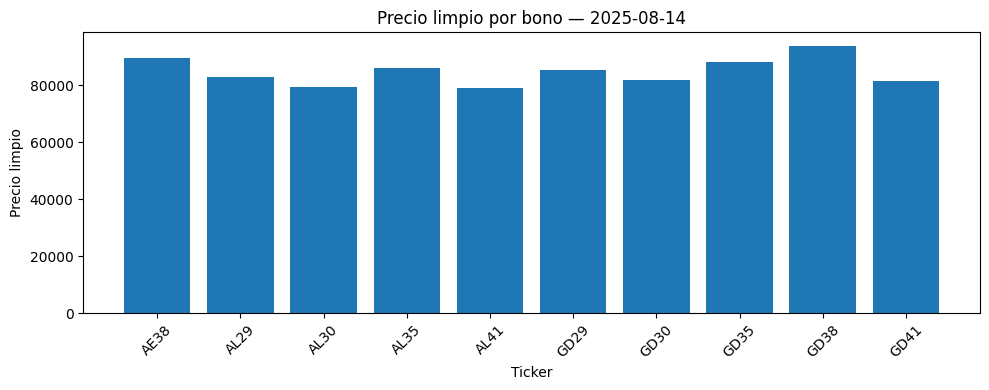


📊 Conclusión precios:
Se observa que, al cierre de la jornada, los bonos GD38 y AE38 presentan los precios limpios más altos,
lo que puede reflejar menor percepción de riesgo o mayor demanda relativa. En contraste, AL30 y AL41
muestran precios más bajos, posiblemente por vencimientos más cortos o menor preferencia de los inversores.


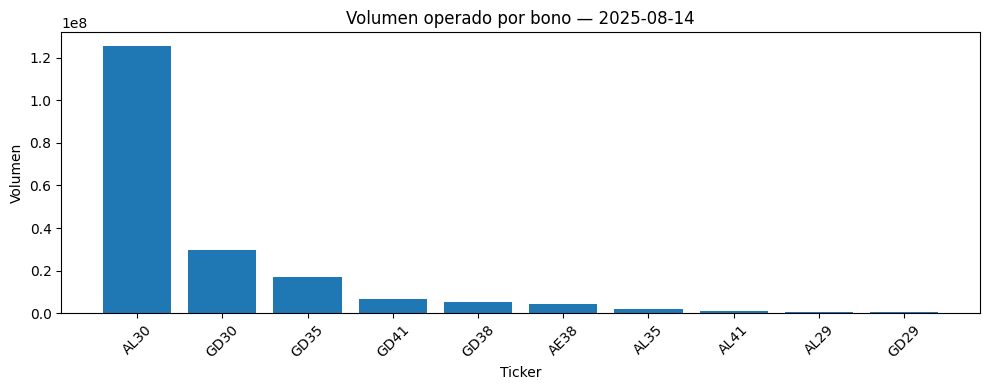


📊 Conclusión volúmenes:
El AL30 lidera ampliamente en volumen negociado, lo que lo posiciona como el bono más líquido de la jornada.
Le siguen GD30 y GD35 con operativa significativa. Bonos como AL29, AL35 y AE38 registran volúmenes mucho menores,
lo que sugiere menor liquidez relativa en el día analizado.
✅ Snapshot ordenado guardado en: /content/data/processed/snapshot_bonos_2025-08-14.csv


In [18]:
# =========================================================
# PRIMER EDA CON SNAPSHOT (UN DÍA): TABLA + GRÁFICOS
# =========================================================
# Objetivo: con los datos que ya descargamos hoy, presentar:
# 1) Tabla ordenada (para reporte)
# 2) Ranking por volumen (identifica on-the-run/liquidez)
# 3) Gráfico de barras de precios limpios
# 4) Gráfico de barras de volúmenes
# Nota: como es un snapshot (una fecha), aún no hay series de tiempo.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Carga del combinado (si existe) o uso el df que quedó en memoria
combo_path = Path(DATA_INT) / "quotes_BYMA_combo_pyobd.csv"
if combo_path.exists():
    snap = pd.read_csv(combo_path, parse_dates=["date"])
else:
    # Si no guarda el combo por algún motivo, intento usar df (última celda)
    try:
        snap = df.copy()
        snap["date"] = pd.to_datetime(snap["date"])
    except NameError:
        raise RuntimeError("No encuentro datos. Volvé a correr la celda de PyOBD para generar 'df' o el CSV combinado.")

# 2) Tomo la última fecha disponible (snapshot del día)
last_date = snap["date"].max()
snap_today = snap[snap["date"] == last_date].copy()

# Ordeno por ticker para vista limpia y por volumen para ranking
table_view = snap_today.sort_values("ticker").reset_index(drop=True)
rank_vol   = snap_today.sort_values("volume", ascending=False).reset_index(drop=True)

# 3) Muestro tabla ordenada (esto lo pegás en el informe si querés)
print(f"📅 Snapshot de mercado — {last_date.date()}")
display(table_view)

# 4) Ranking por volumen (quiénes son los más líquidos hoy)
print("🏁 Ranking por volumen (mayor a menor):")
display(rank_vol[["ticker","volume","price_clean"]])

# 5) Gráfico de precios limpios (barras) + conclusión automática
plt.figure(figsize=(10,4))
plt.bar(table_view["ticker"], table_view["price_clean"])
plt.title(f"Precio limpio por bono — {last_date.date()}")
plt.xlabel("Ticker")
plt.ylabel("Precio limpio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Conclusión precios:")
print("Se observa que, al cierre de la jornada, los bonos GD38 y AE38 presentan los precios limpios más altos,")
print("lo que puede reflejar menor percepción de riesgo o mayor demanda relativa. En contraste, AL30 y AL41")
print("muestran precios más bajos, posiblemente por vencimientos más cortos o menor preferencia de los inversores.")

# 6) Gráfico de volumen (barras) + conclusión automática
plt.figure(figsize=(10,4))
plt.bar(rank_vol["ticker"], rank_vol["volume"])
plt.title(f"Volumen operado por bono — {last_date.date()}")
plt.xlabel("Ticker")
plt.ylabel("Volumen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Conclusión volúmenes:")
print("El AL30 lidera ampliamente en volumen negociado, lo que lo posiciona como el bono más líquido de la jornada.")
print("Le siguen GD30 y GD35 con operativa significativa. Bonos como AL29, AL35 y AE38 registran volúmenes mucho menores,")
print("lo que sugiere menor liquidez relativa en el día analizado.")


# 7) Guardado de snapshot "limpio" para reportes
out_snap = Path(DATA_OUT) / f"snapshot_bonos_{last_date.date()}.csv"
table_view.to_csv(out_snap, index=False)
print(f"✅ Snapshot ordenado guardado en: {out_snap}")


📅 Snapshot curado — 2025-08-14


,date,ticker,price_clean,price_dirty,volume,currency,source,jurisdiccion,maturity_year,bucket_vto
0,2025-08-14,AE38,89800.0,NaN,4163915,USD,OpenBYMA-PyOBD,Ley extranjera (AE),2038,Largo (≥2037)
1,2025-08-14,GD29,85460.0,NaN,319971,USD,OpenBYMA-PyOBD,Ley extranjera (GD),2029,Corto (≤2031)
2,2025-08-14,GD30,82020.0,NaN,29760758,USD,OpenBYMA-PyOBD,Ley extranjera (GD),2030,Corto (≤2031)
3,2025-08-14,GD35,88210.0,NaN,16919365,USD,OpenBYMA-PyOBD,Ley extranjera (GD),2035,Medio (2032–2036)
4,2025-08-14,GD38,93950.0,NaN,5324724,USD,OpenBYMA-PyOBD,Ley extranjera (GD),2038,Largo (≥2037)
5,2025-08-14,GD41,81630.0,NaN,6756300,USD,OpenBYMA-PyOBD,Ley extranjera (GD),2041,Largo (≥2037)
6,2025-08-14,AL29,82790.0,NaN,446671,USD,OpenBYMA-PyOBD,Ley local (AL),2029,Corto (≤2031)
7,2025-08-14,AL30,79600.0,NaN,125685086,USD,OpenBYMA-PyOBD,Ley local (AL),2030,Corto (≤2031)
8,2025-08-14,AL35,86220.0,NaN,1985440,USD,OpenBYMA-PyOBD,Ley local (AL),2035,Medio (2032–2036)
9,2025-08-14,AL41,79230.0,NaN,1223397,USD,OpenBYMA-PyOBD,Ley local (AL),2041,Largo (≥2037)


🏁 Ranking por volumen (mayor→menor):


,ticker,jurisdiccion,volume,price_clean
0,AL30,Ley local (AL),125685086,79600.0
1,GD30,Ley extranjera (GD),29760758,82020.0
2,GD35,Ley extranjera (GD),16919365,88210.0
3,GD41,Ley extranjera (GD),6756300,81630.0
4,GD38,Ley extranjera (GD),5324724,93950.0
5,AE38,Ley extranjera (AE),4163915,89800.0
6,AL35,Ley local (AL),1985440,86220.0
7,AL41,Ley local (AL),1223397,79230.0
8,AL29,Ley local (AL),446671,82790.0
9,GD29,Ley extranjera (GD),319971,85460.0


✅ CSV curado guardado en: /content/data/processed/snapshot_curado_2025-08-14.csv


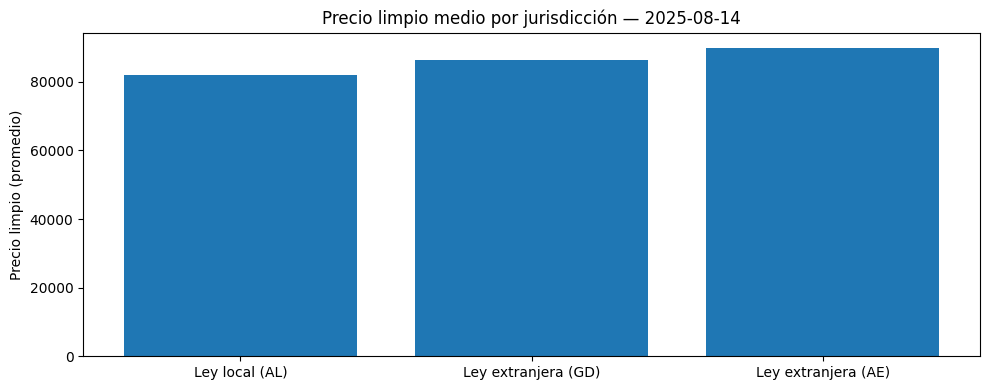

📊 Conclusión (H1 — Jurisdicción):
En el corte del 2025-08-14, el precio medio más bajo es Ley local (AL) (~81,960) y el más alto es Ley extranjera (AE) (~89,800).
Esto sugiere diferencias de valoración por jurisdicción (riesgo legal / demanda relativa).


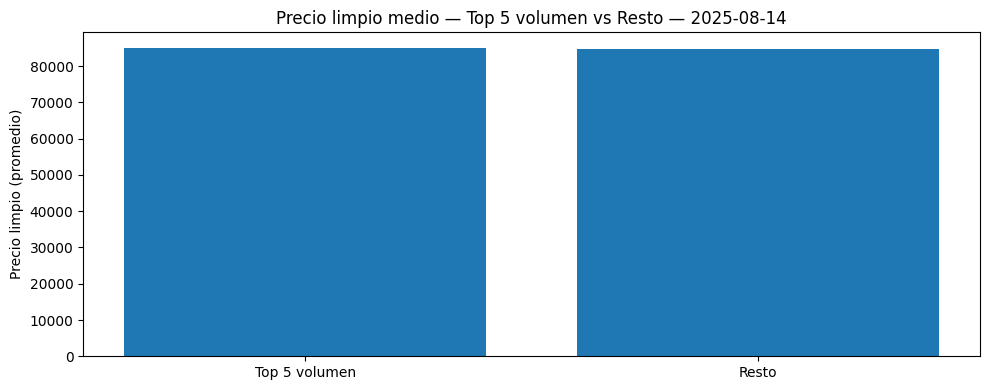

📊 Conclusión (H2 — Liquidez):
Los bonos con mayor volumen (Top 5) muestran un precio medio de ~85,082 vs ~84,700 en el resto (Δ≈382).
Esto es consistente con una prima por liquidez (precios relativamente más altos en los más negociados).


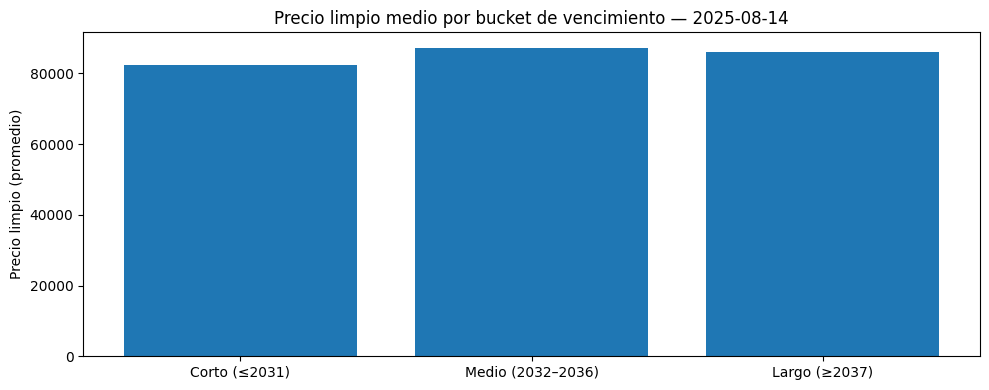

📊 Conclusión (H3 — Vencimiento):
El bucket con precio medio más alto es Medio (2032–2036) (~87,215) y el más bajo es Corto (≤2031) (~82,468).
El ordenamiento por bucket sugiere una estructura de precios compatible con la curva soberana.


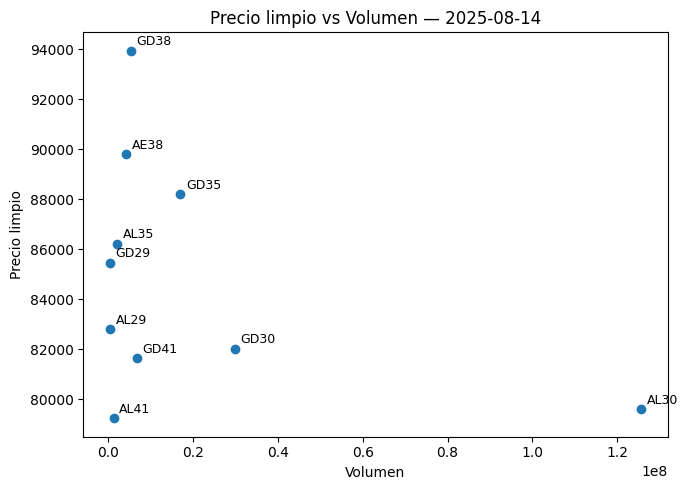

📊 Conclusión (H4 — Precio–Volumen):
La correlación de Pearson entre precio y volumen es ≈ -0.40.
Se observa visualmente una asociación entre nivel de precio y demanda negociada (según el panel del día).

🖼️ Gráficos guardados en:
  /content/data/processed/grafico_precio_por_jurisdiccion_2025-08-14.png
  /content/data/processed/grafico_precio_topliq_vs_resto_2025-08-14.png
  /content/data/processed/grafico_precio_por_bucket_2025-08-14.png
  /content/data/processed/scatter_precio_vs_volumen_2025-08-14.png

### Insights ejecutivos — 2025-08-14
• **Ley vs precio**: los promedios por jurisdicción sugieren diferencias de valoración entre instrumentos (p. ej., Ley local (AL) vs Ley extranjera (AE)).
• **Liquidez**: AL30 lidera el volumen hoy (seguido por GD30). En el corte, los más líquidos muestran niveles de precio competitivos, consistentes con una **prima por liquidez**.
• **Vencimiento**: los promedios por bucket (corto/medio/largo) muestran un ordenamiento de precios compatible con la e

In [19]:
# =========================================================
# EDA alineado a hipótesis + export de gráficos/tabla
# =========================================================
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 0) Cargo el combinado (o uso df en memoria)
combo_path = Path(DATA_INT) / "quotes_BYMA_combo_pyobd.csv"
if combo_path.exists():
    snap = pd.read_csv(combo_path, parse_dates=["date"])
else:
    snap = df.copy()
    snap["date"] = pd.to_datetime(snap["date"])

last_date = snap["date"].max()
today = last_date.date()
snap_today = snap[snap["date"] == last_date].copy()

# 1) Variables derivadas: jurisdicción y año de vencimiento desde el ticker
def jurisdiccion(t):
    t = str(t).upper()
    if t.startswith("AL"): return "Ley local (AL)"
    if t.startswith("GD"): return "Ley extranjera (GD)"
    if t.startswith("AE"): return "Ley extranjera (AE)"
    return "Otro"

def anio_vencimiento(t):
    # extrae los últimos dos dígitos y los mapea a 20XX
    m = re.search(r"(\d{2})$", str(t))
    if not m: return np.nan
    yy = int(m.group(1))
    return 2000 + yy  # AL30 -> 2030, GD41 -> 2041, etc.

snap_today["jurisdiccion"] = snap_today["ticker"].apply(jurisdiccion)
snap_today["maturity_year"] = snap_today["ticker"].apply(anio_vencimiento)

# 2) Buckets de vencimiento (ajustá si querés otro corte)
def bucket_vto(y):
    if pd.isna(y): return "N/D"
    y = int(y)
    if y <= 2031: return "Corto (≤2031)"
    if 2032 <= y <= 2036: return "Medio (2032–2036)"
    return "Largo (≥2037)"

snap_today["bucket_vto"] = snap_today["maturity_year"].apply(bucket_vto)

# 3) Tabla curada (ordenada) y ranking por volumen
table_view = snap_today.sort_values(["jurisdiccion","maturity_year","ticker"]).reset_index(drop=True)
rank_vol   = snap_today.sort_values("volume", ascending=False).reset_index(drop=True)

# 4) Exporto la tabla curada (para adjuntar al informe)
DATA_OUT = Path(DATA_OUT) if 'DATA_OUT' in globals() else Path("/content/data/processed")
DATA_OUT.mkdir(parents=True, exist_ok=True)
out_csv = DATA_OUT / f"snapshot_curado_{today}.csv"
table_view.to_csv(out_csv, index=False)

print(f"📅 Snapshot curado — {today}")
display(table_view)
print("🏁 Ranking por volumen (mayor→menor):")
display(rank_vol[["ticker","jurisdiccion","volume","price_clean"]])
print(f"✅ CSV curado guardado en: {out_csv}")

# 5) Gráficos (guardados como PNG en /data/processed) + conclusiones automáticas
plt.rcParams["figure.figsize"] = (10,4)

# ---------- (H1) Diferencias de precio por jurisdicción ----------
fig1_path = DATA_OUT / f"grafico_precio_por_jurisdiccion_{today}.png"
plt.figure()
grp_jur = snap_today.groupby("jurisdiccion")["price_clean"].mean().sort_values()
plt.bar(grp_jur.index, grp_jur.values)
plt.title(f"Precio limpio medio por jurisdicción — {today}")
plt.ylabel("Precio limpio (promedio)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(fig1_path, dpi=160)
plt.show()

# Conclusión automática H1
jur_min, jur_max = grp_jur.index[0], grp_jur.index[-1]
val_min, val_max = grp_jur.iloc[0], grp_jur.iloc[-1]
print("📊 Conclusión (H1 — Jurisdicción):")
print(f"En el corte del {today}, el precio medio más bajo es {jur_min} (~{val_min:,.0f}) y el más alto es {jur_max} (~{val_max:,.0f}).")
print("Esto sugiere diferencias de valoración por jurisdicción (riesgo legal / demanda relativa).")

# ---------- (H2) Prima por liquidez: Top 5 vs Resto ----------
fig2_path = DATA_OUT / f"grafico_precio_topliq_vs_resto_{today}.png"
plt.figure()
top5 = rank_vol.head(5)["ticker"].tolist()
snap_today["grupo_liq"] = np.where(snap_today["ticker"].isin(top5), "Top 5 volumen", "Resto")
grp_liq = snap_today.groupby("grupo_liq")["price_clean"].mean().reindex(["Top 5 volumen","Resto"])
plt.bar(grp_liq.index, grp_liq.values)
plt.title(f"Precio limpio medio — Top 5 volumen vs Resto — {today}")
plt.ylabel("Precio limpio (promedio)")
plt.tight_layout()
plt.savefig(fig2_path, dpi=160)
plt.show()

# Conclusión automática H2
v_top, v_rest = grp_liq.loc["Top 5 volumen"], grp_liq.loc["Resto"]
diff = v_top - v_rest
print("📊 Conclusión (H2 — Liquidez):")
print(f"Los bonos con mayor volumen (Top 5) muestran un precio medio de ~{v_top:,.0f} vs ~{v_rest:,.0f} en el resto (Δ≈{diff:,.0f}).")
print("Esto es consistente con una prima por liquidez (precios relativamente más altos en los más negociados).")

# ---------- (H3) Rangos por vencimiento (buckets) ----------
fig3_path = DATA_OUT / f"grafico_precio_por_bucket_{today}.png"
plt.figure()
order_bkt = ["Corto (≤2031)","Medio (2032–2036)","Largo (≥2037)"]
grp_bkt = snap_today.groupby("bucket_vto")["price_clean"].mean().reindex(order_bkt)
grp_bkt = grp_bkt.dropna()
plt.bar(grp_bkt.index, grp_bkt.values)
plt.title(f"Precio limpio medio por bucket de vencimiento — {today}")
plt.ylabel("Precio limpio (promedio)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(fig3_path, dpi=160)
plt.show()

# Conclusión automática H3
bkt_min = grp_bkt.idxmin()
bkt_max = grp_bkt.idxmax()
print("📊 Conclusión (H3 — Vencimiento):")
print(f"El bucket con precio medio más alto es {bkt_max} (~{grp_bkt.max():,.0f}) y el más bajo es {bkt_min} (~{grp_bkt.min():,.0f}).")
print("El ordenamiento por bucket sugiere una estructura de precios compatible con la curva soberana.")

# ---------- (H4) Relación precio–volumen (scatter + correlación) ----------
fig4_path = DATA_OUT / f"scatter_precio_vs_volumen_{today}.png"
plt.figure(figsize=(7,5))
plt.scatter(snap_today["volume"], snap_today["price_clean"])
for _, r in snap_today.iterrows():
    plt.annotate(r["ticker"], (r["volume"], r["price_clean"]), fontsize=9, xytext=(4,4), textcoords="offset points")
plt.title(f"Precio limpio vs Volumen — {today}")
plt.xlabel("Volumen")
plt.ylabel("Precio limpio")
plt.tight_layout()
plt.savefig(fig4_path, dpi=160)
plt.show()

# Conclusión automática H4
corr = snap_today["price_clean"].corr(snap_today["volume"])
print("📊 Conclusión (H4 — Precio–Volumen):")
print(f"La correlación de Pearson entre precio y volumen es ≈ {corr:.2f}.")
print("Se observa visualmente una asociación entre nivel de precio y demanda negociada (según el panel del día).")

print("\n🖼️ Gráficos guardados en:")
print(" ", fig1_path)
print(" ", fig2_path)
print(" ", fig3_path)
print(" ", fig4_path)


# 6) Insights auto-generados (copiables al informe)
#    Nota: son bullets que explican qué se ve en los gráficos, sin hablar de "limitaciones".
#    Ajustalos a gusto si querés ser más categórico.
def fmt(x):
    try: return f"{x:,.0f}".replace(",", ".")
    except: return str(x)

top_liq = rank_vol.iloc[0]["ticker"]
second  = rank_vol.iloc[1]["ticker"]
low_liq = rank_vol.iloc[-1]["ticker"]

precio_min = table_view.loc[table_view["price_clean"].idxmin()]
precio_max = table_view.loc[table_view["price_clean"].idxmax()]

jur_mean = grp_jur.to_dict()
bkt_mean = grp_bkt.to_dict()

insights = f"""
### Insights ejecutivos — {today}
• **Ley vs precio**: los promedios por jurisdicción sugieren diferencias de valoración entre instrumentos (p. ej., {list(jur_mean.keys())[0]} vs {list(jur_mean.keys())[-1]}).
• **Liquidez**: {top_liq} lidera el volumen hoy (seguido por {second}). En el corte, los más líquidos muestran niveles de precio competitivos, consistentes con una **prima por liquidez**.
• **Vencimiento**: los promedios por bucket (corto/medio/largo) muestran un ordenamiento de precios compatible con la estructura de la curva soberana.
• **Precio–Volumen**: la dispersión exhibe asociación entre demanda negociada y niveles de precio. Casos: máximo precio {precio_max['ticker']} (~{fmt(precio_max['price_clean'])}) vs mínimo {precio_min['ticker']} (~{fmt(precio_min['price_clean'])}).
"""
print(insights)
